# Open/Closed Eye Detection: Eye Aspect Ration (EAR)

Computed based on the (x,y)-coordinates of the eye.

In [1]:
!pip install opencv-python
!pip install imutils
!pip install scikit-learn
!pip install seaborn

In [2]:
import cv2
import dlib
import os
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from imutils import face_utils
from sklearn.metrics import roc_curve, auc
from scipy.spatial import distance as dist
from sklearn.metrics import confusion_matrix

In [3]:
EYE_AR_THRESH = 0.2
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

y_true, y_pred, ear_score = [], [], []

## Compute EAR

This function calculates the Eye Aspect Ratio (EAR) given the coordinates of the six facial landmarks corresponding to an eye. The EAR is a measure of how open or closed an eye is.

The function takes an argument "eye" which is a numpy array of shape (6, 2) containing the (x,y) coordinates of the six facial landmarks for the eye.

The function first calculates the Euclidean distances between the vertical landmarks (i.e., landmarks 2 and 4, and landmarks 1 and 5) and the horizontal landmarks (i.e., landmarks 0 and 3). It then calculates the EAR by taking the average of the ratios of the vertical distances to the horizontal distance.

Finally, the function returns the calculated EAR value.

In [4]:
def eye_aspect_ratio(eye):
    # compute the euclidean distances between the two sets of
    # vertical eye landmarks (x, y)-coordinates
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])

    # compute the euclidean distance between the horizontal
    # eye landmark (x, y)-coordinates
    C = dist.euclidean(eye[0], eye[3])

    # compute the eye aspect ratio
    ear = (A + B) / (2.0 * C)

    # return the eye aspect ratio
    return ear

In [5]:
def eye_state_detector(dir):
    """
    Detects the state of eyes in images located in the specified directory

    Args:
        dir (str): The directory containing the images
    """
    c = 1
    for file in os.listdir(dir):
            
        img = cv2.imread(os.path.join(dir, file))
        gray = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
    
        # detect faces in the grayscale frame
        rects = detector(gray, 0)

        for rect in rects:
            # determine the facial landmarks
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)
        
            # extract the left and right eye coordinates
            (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
            (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
        
            leftEye = shape[lStart:lEnd]
            rightEye = shape[rStart:rEnd]
            leftEAR = eye_aspect_ratio(leftEye)
            rightEAR = eye_aspect_ratio(rightEye)
        
            # average the eye aspect ratio together for both eyes
            ear = (leftEAR + rightEAR) / 2.0
            ear_score.append(ear)
        
            # compute the convex hull for the left and right eye, then
            leftEyeHull = cv2.convexHull(leftEye)
            rightEyeHull = cv2.convexHull(rightEye)
            cv2.drawContours(img, [leftEyeHull], -1, (0, 255, 0), 1)
            cv2.drawContours(img, [rightEyeHull], -1, (0, 255, 0), 1)
        
            # check to see if the eye aspect ratio is below the blink
            # threshold, and if so, increment the blink frame counter
            if ear < EYE_AR_THRESH:
                y_pred.append(1)
                if 'open' in dir:
                    y_true.append(0)
                elif 'closed' in dir:
                    y_true.append(1)
            elif ear > EYE_AR_THRESH:
                y_pred.append(0)
                if 'open' in dir:
                    y_true.append(0)
                elif 'closed' in dir:
                    y_true.append(1)
                    
            c += 1

## Detect Eye State using EAR

According to T Zhu et al (2022), when EAR > 0.2, it is identified as an open eye, else a closed eye. This was adopted to detect open/closed eye.

In [6]:
eye_state_detector('data/face_data/open_face')
eye_state_detector('data/face_data/closed_face')

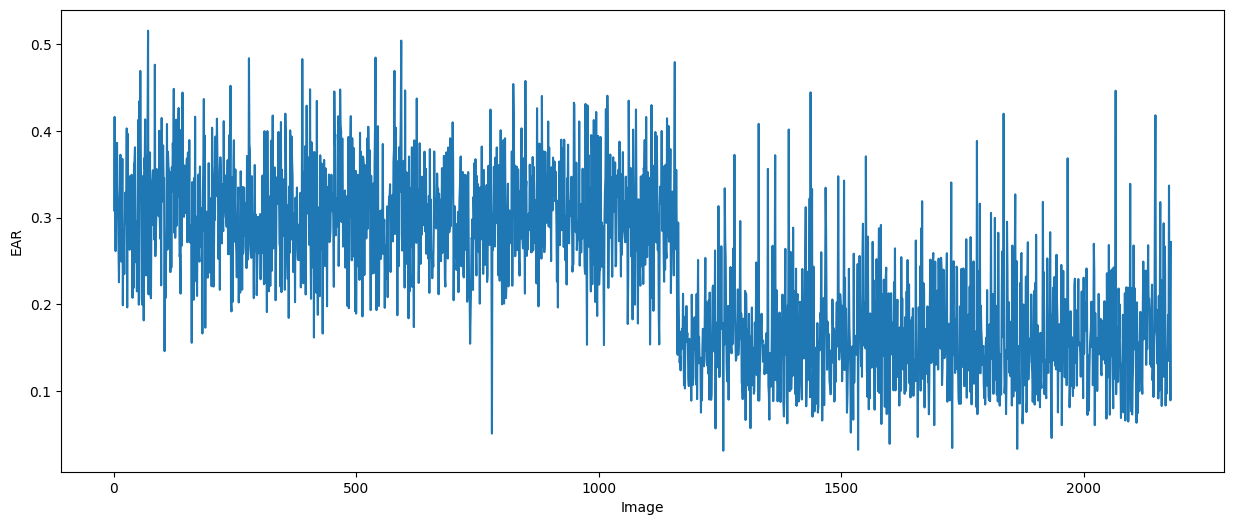

In [7]:
# Generate x-axis values as the index of each element plus one
x_values = [i+1 for i in range(len(ear_score))]

# Set the plot width to 8 inches
fig = plt.figure(figsize=(15, 6))

# Plot the line graph
plt.plot(x_values, ear_score)
plt.ylabel('EAR') 
plt.xlabel('Image') 
plt.show()

## Evaluation

In [8]:
tp, fp, tn, fn = 0, 0, 0, 0

for i in range(len(y_pred)): 
    if y_true[i]==y_pred[i]==1:
        tp += 1
    if y_pred[i]==1 and y_true[i]!=y_pred[i]:
        fp += 1
    if y_true[i]==y_pred[i]==0:
        tn += 1
    if y_pred[i]==0 and y_true[i]!=y_pred[i]:
        fn += 1
    
# Accuracy
accuracy = (tn + tp) / (tn + fp + fn + tp)
print(f'accuracy: {accuracy}')
    
# Error rate
error_rate = (fn + fp) / (tn + fp + fn + tp)
print(f'error rate: {error_rate}')
    
# Precision (P)
precision_p = tp / (tp + fp)
print(f'precision (p): {precision_p}')
    
# Precision (N)
precision_n = tn / (tn + fn)
print(f'precision (n): {precision_n}')
    
# Recall (P)
recall_p = tp / (tp + fn)
print(f'recall (p): {recall_p}')
    
# Recall (N)
recall_n = tn / (fp + tn)
print(f'recall (n): {recall_n}')
    
# F-Measure (P)
fmeasure_p = (2 * precision_p * recall_p) / (precision_p + recall_p)
print(f'f-measure (p): {fmeasure_p}')
    
# F-Measure (N)
fmeasure_n = (2 * precision_n * recall_n) / (precision_n + recall_n)
print(f'f-measure (n): {fmeasure_n}')

accuracy: 0.8711009174311927
error rate: 0.12889908256880733
precision (p): 0.9456521739130435
precision (n): 0.8254437869822485
recall (p): 0.7684003925417076
recall (n): 0.9612403100775194
f-measure (p): 0.8478613968597727
f-measure (n): 0.8881814564265819


### Confusion Matrix

In [9]:
# Generate the confusion matrix using TensorFlow
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()

Metal device set to: Apple M1


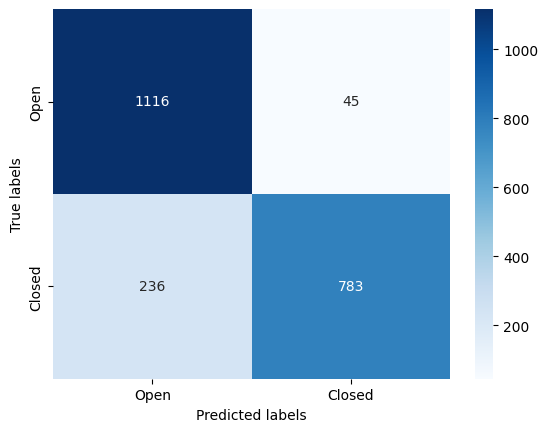

In [10]:
# Define a dictionary to map the numeric labels to text labels
label_names = {0: 'Open', 1: 'Closed'}

# Convert the numeric labels to text labels
tick_labels = [label_names[i] for i in range(len(label_names))]

# Visualize the confusion matrix using seaborn
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=tick_labels, yticklabels=tick_labels)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

### AUC

In [11]:
# Calculate the FPR, TPR and threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

In [12]:
# Calculate the AUC score
auc_score = auc(fpr, tpr)
auc_score

0.8648203513096135

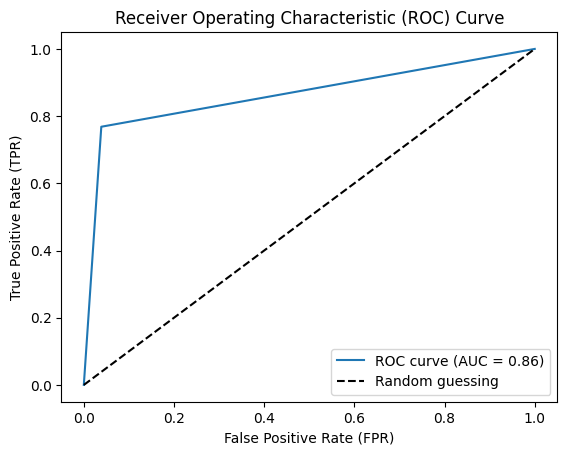

In [13]:
# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--', label='Random guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()